# Determining the optimal timing for insulin injection to minimize glucose level variability after a meal in ideal conditions

Import necessary libraries

In [16]:
from IPython.display import display_html
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from itertools import zip_longest 
import scipy.optimize as opt
from scipy import integrate
import statistics as stats
import numpy.ma as ma
import pandas as pd
import sympy as sy
import numpy as np
import datetime
import math

## Data processing

Import data

In [3]:
data = pd.read_csv('Data_27-1.csv')

Format data

In [4]:
#Format data
concise_data = data.drop(index=data.index[:10], columns=['Patient Info', 'Device Info', 'Source Device ID'])
concise_data.reset_index(drop=True, inplace=True)
concise_data['Index'] = concise_data['Index'].sub(11)

#MultiIndex
concise_data.index = pd.MultiIndex.from_frame(concise_data)
concise_data.sort_index(inplace=True)

Sample of data showing all relevant event types

In [5]:
concise_data.iloc[206:10176]

,,,,,,,,,,,Index,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Glucose Value (mmol/L),Insulin Value (u),Carb Value (grams),Duration (hh:mm:ss),Glucose Rate of Change (mmol/L/min),Transmitter Time (Long Integer),Transmitter ID
Index,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Event Subtype,Glucose Value (mmol/L),Insulin Value (u),Carb Value (grams),Duration (hh:mm:ss),Glucose Rate of Change (mmol/L/min),Transmitter Time (Long Integer),Transmitter ID,,,,,,,,,,,
206,2021-10-27T17:05:31,EGV,NaN,6.2,NaN,NaN,NaN,NaN,8832673.0,8PBGYQ,206,2021-10-27T17:05:31,EGV,NaN,6.2,NaN,NaN,NaN,NaN,8832673.0,8PBGYQ
207,2021-10-27T17:06:00,Carbs,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,207,2021-10-27T17:06:00,Carbs,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
208,2021-10-27T17:10:30,EGV,NaN,6.4,NaN,NaN,NaN,NaN,8832973.0,8PBGYQ,208,2021-10-27T17:10:30,EGV,NaN,6.4,NaN,NaN,NaN,NaN,8832973.0,8PBGYQ
209,2021-10-27T17:15:30,EGV,NaN,6.9,NaN,NaN,NaN,NaN,8833273.0,8PBGYQ,209,2021-10-27T17:15:30,EGV,NaN,6.9,NaN,NaN,NaN,NaN,8833273.0,8PBGYQ
210,2021-10-27T17:20:30,EGV,NaN,7.4,NaN,NaN,NaN,NaN,8833573.0,8PBGYQ,210,2021-10-27T17:20:30,EGV,NaN,7.4,NaN,NaN,NaN,NaN,8833573.0,8PBGYQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,2021-11-30T08:52:55,EGV,NaN,10.8,NaN,NaN,NaN,NaN,2362573.0,8J44L8,10171,2021-11-30T08:52:55,EGV,NaN,10.8,NaN,NaN,NaN,NaN,2362573.0,8J44L8
10172,2021-11-30T08:57:55,EGV,NaN,10.6,NaN,NaN,NaN,NaN,2362873.0,8J44L8,10172,2021-11-30T08:57:55,EGV,NaN,10.6,NaN,NaN,NaN,NaN,2362873.0,8J44L8
10173,2021-11-30T08:59:00,Insulin,Fast-Acting,NaN,1.0,NaN,NaN,NaN,NaN,NaN,10173,2021-11-30T08:59:00,Insulin,Fast-Acting,NaN,1.0,NaN,NaN,NaN,NaN,NaN


Format data without index column in MultiIndex  
<span style="font-size: 12px">(To retain indexing functionality within certain functions)</span>

In [6]:
concise_data_woI = data.drop(index=data.index[:10], columns=['Index', 'Patient Info', 'Device Info', 'Source Device ID'])
concise_data_woI.reset_index(drop=True, inplace=True)
concise_data_woI.index = pd.MultiIndex.from_frame(concise_data_woI)
concise_data_woI.sort_index(inplace=True)

Isolate and convert `time` variable to datetime

In [7]:
time = pd.to_datetime(concise_data['Timestamp (YYYY-MM-DDThh:mm:ss)'])

Isolate and convert `glucose` variable to float64  

> <span style="font-size: 12px">call range by `glucose.loc[slice(None), 'YYYY-MM-DDThh:mm:ss':'YYYY-MM-DDThh:mm:ss']`</span>  
> <span style="font-size: 10px">where Y = year, M = month, D = day, T = separator, h = hour, m = minute, s = second</span>

In [8]:
glucose = pd.to_numeric(concise_data['Glucose Value (mmol/L)'], errors='coerce')

`glucose` variable without index column in MultiIndex  
<span style="font-size: 12px">(To retain indexing functionality within `get_glucose_minmax` function)</span>

In [9]:
glucose_woI = pd.to_numeric(concise_data_woI['Glucose Value (mmol/L)'], errors='coerce')

All times when 10.5 carbohydrates (5 'Siripiri' tablets) were consumed

In [10]:
_10carbs_timing = concise_data['Timestamp (YYYY-MM-DDThh:mm:ss)'].loc[(concise_data['Event Type'] == 'Carbs') & (concise_data['Carb Value (grams)'] == 10)].values
_10carbs_timing

array(['2021-10-27T17:06:00', '2021-10-28T19:00:00',
       '2021-10-28T19:30:00', '2021-10-29T07:49:00',
       '2021-10-29T09:37:00', '2021-10-29T11:11:00',
       '2021-10-29T14:04:00', '2021-10-29T15:27:00',
       '2021-10-31T12:53:00', '2021-11-02T09:50:00',
       '2021-11-02T11:51:00', '2021-11-02T19:00:00',
       '2021-11-03T08:13:00', '2021-11-03T11:04:00',
       '2021-11-03T14:19:00', '2021-11-04T18:27:00',
       '2021-11-05T05:07:00', '2021-11-05T08:18:00',
       '2021-11-05T12:01:00', '2021-11-05T14:08:00',
       '2021-11-09T09:08:00', '2021-11-10T14:49:00',
       '2021-11-11T02:16:00', '2021-11-11T14:28:00',
       '2021-11-12T08:43:00', '2021-11-12T15:05:00',
       '2021-11-13T16:42:00', '2021-11-16T14:48:00',
       '2021-11-17T09:18:00', '2021-11-19T08:30:00',
       '2021-11-19T20:11:00', '2021-11-22T08:23:00',
       '2021-11-24T08:39:00', '2021-11-24T14:09:00',
       '2021-11-25T12:14:00', '2021-11-26T08:21:00',
       '2021-11-26T13:25:00', '2021-11-29T13:4

All times when 1 unit of insulin was injected

In [11]:
fa_insulin_1u_timing = concise_data['Timestamp (YYYY-MM-DDThh:mm:ss)'].loc[(concise_data['Event Subtype'] == 'Fast-Acting') & (concise_data['Insulin Value (u)'] == 1.0)].values
fa_insulin_1u_timing

array(['2021-10-28T09:51:00', '2021-10-28T11:44:00',
       '2021-10-29T17:31:00', '2021-10-29T21:42:00',
       '2021-10-30T16:22:00', '2021-10-31T00:12:00',
       '2021-10-31T09:40:00', '2021-10-31T16:02:00',
       '2021-11-01T13:37:00', '2021-11-01T17:01:00',
       '2021-11-01T17:43:00', '2021-11-02T07:37:00',
       '2021-11-04T09:19:00', '2021-11-04T10:38:00',
       '2021-11-05T10:17:00', '2021-11-06T11:41:00',
       '2021-11-07T00:18:00', '2021-11-07T01:33:00',
       '2021-11-07T13:03:00', '2021-11-07T17:31:00',
       '2021-11-07T18:17:00', '2021-11-08T15:07:00',
       '2021-11-09T07:52:00', '2021-11-09T11:21:00',
       '2021-11-10T09:08:00', '2021-11-10T11:49:00',
       '2021-11-11T10:18:00', '2021-11-11T12:03:00',
       '2021-11-11T16:10:00', '2021-11-12T00:48:00',
       '2021-11-12T11:29:00', '2021-11-12T23:52:00',
       '2021-11-13T09:02:00', '2021-11-13T12:10:00',
       '2021-11-13T20:05:00', '2021-11-13T20:49:00',
       '2021-11-15T08:16:00', '2021-11-15T13:1

Plot of glucose levels and insulin and carbohydrate timings between 27.10.2021 and 1.12.2021

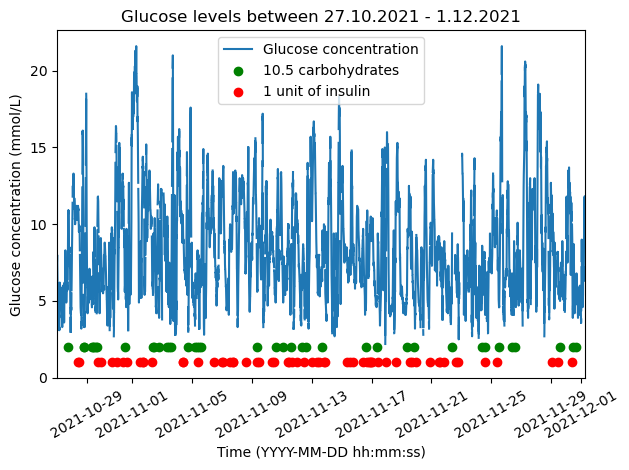

In [13]:
plt.plot(time, glucose)
plt.scatter(_10carbs_timing, ([2] * len(_10carbs_timing)), color='green', marker='o')
plt.scatter(fa_insulin_1u_timing, ([1] * len(fa_insulin_1u_timing)), color='red', marker='o')
plt.title('Glucose levels between 27.10.2021 - 1.12.2021')
plt.legend(['Glucose concentration', '10.5 carbohydrates', '1 unit of insulin'])
plt.xlabel('Time (YYYY-MM-DD hh:mm:ss)')
plt.ylabel('Glucose concentration (mmol/L)')
plt.xlim(time.iloc[0], time.iloc[-1])

plt.xticks(rotation = 30)
plt.tight_layout()

#fig=plt.figure(figsize=(80,80), dpi= 200, facecolor='w', edgecolor='k')
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams['figure.dpi'] = 200
plt.savefig(fname='Glucose levels between 27.10.2021 - 1.12.2021.')

plt.style.use('default')

Table of raw data with consumption of 10.5 carbohydrates highlighted in green and injection of 1 unit of insulin highlighted in red (display removed for notebook conciseness, result can be seen in the appendices of [this paper](https://ibdone1.files.wordpress.com/2023/01/mathematics-ia-determining-the-optimal-timing-of-insulin-injection-with-raw-data.pdf))

In [14]:
two_column_data = concise_data_woI.iloc[:,np.r_[0,3]]
two_column_data.reset_index(drop=True, inplace=True)

In [34]:
def style_carbs(v, props=''):
    return props if v in _10carbs_timing else None
def style_insulin(v, props=''):
    return props if v in fa_insulin_1u_timing else None

In [32]:
raw_data_part_1 = two_column_data.iloc[0:2610]
raw_data_part_2 = two_column_data.iloc[2611:5220]
raw_data_part_3 = two_column_data.iloc[5221:7830]
raw_data_part_4 = two_column_data.iloc[7831:]
raw_data_used_1 = raw_data_part_1.style.applymap(style_carbs, props='background-color:green; color:white;').applymap(style_insulin, props='background-color:red; color:white;')\
              .applymap(lambda v: 'opacity: 80%;' if v in _10carbs_timing else None).applymap(lambda v: 'opacity: 80%;' if v in fa_insulin_1u_timing else None).set_table_styles([dict(selector="th",props=[('max-width', '80px')])]).set_table_attributes("style='display:inline'")
raw_data_used_2 = raw_data_part_2.style.applymap(style_carbs, props='background-color:green; color:white;').applymap(style_insulin, props='background-color:red; color:white;')\
              .applymap(lambda v: 'opacity: 80%;' if v in _10carbs_timing else None).applymap(lambda v: 'opacity: 80%;' if v in fa_insulin_1u_timing else None).set_table_styles([dict(selector="th",props=[('max-width', '80px')])]).set_table_attributes("style='display:inline'")
raw_data_used_3 = raw_data_part_3.style.applymap(style_carbs, props='background-color:green; color:white;').applymap(style_insulin, props='background-color:red; color:white;')\
              .applymap(lambda v: 'opacity: 80%;' if v in _10carbs_timing else None).applymap(lambda v: 'opacity: 80%;' if v in fa_insulin_1u_timing else None).set_table_styles([dict(selector="th",props=[('max-width', '80px')])]).set_table_attributes("style='display:inline'")
raw_data_used_4 = raw_data_part_4.style.applymap(style_carbs, props='background-color:green; color:white;').applymap(style_insulin, props='background-color:red; color:white;')\
              .applymap(lambda v: 'opacity: 80%;' if v in _10carbs_timing else None).applymap(lambda v: 'opacity: 80%;' if v in fa_insulin_1u_timing else None).set_table_styles([dict(selector="th",props=[('max-width', '80px')])]).set_table_attributes("style='display:inline'")

## Modeling the change in glucose levels after consumption of 10.5 carbohydrates

##### Defining functions and processing data

Make x-axis integer minutes with 5-minute intervals  
<span style="font-size: 12px">(To enable plotting glucose changes from different time intervals in one curve starting from the origin)</span>

In [14]:
x_domain = np.arange(0, 10001, 5)

A function to get the range of glucose values from minimum to maximum in a 3h interval based on a datetime input
> <span style="font-size: 12px">Call function with `get_glucose_minmax(concise_data.loc[(slice(None), 'YYYY-MM-DDThh:mm:ss'), 'Timestamp (YYYY-MM-DDThh:mm:ss)'].values)`</span>  
> <span style="font-size: 10px">where Y = year, M = month, D = day, T = separator, h = hour, m = minute, s = second</span>

3h interval chosen based on personal experience with carbohydrate consumption to manifest full effect while minimizing the effect of other variables (must be same as for insulin). Minimum to maximum approach as an assumption is a key weakness but one made to offset the effect of other variables such as prior "momentum" of the glucose levels and to make data more easy and clean to process, compare and model. 

In [15]:
def get_glucose_minmax(date):
    from_date = tuple(date) #tuple to avoid unhashable type: 'Series' error
    date_format = pd.to_datetime(date) #format object to datetime
    from_date_add_3h = date_format + datetime.timedelta(hours=3) #add 3h to get right bound
    to_date_string = from_date_add_3h.strftime('%Y-%m-%dT%H:%M:%S') #convert to str
    to_date = tuple(to_date_string) #tuple to avoid unhashable type: 'Series' error
    date_3h_range = glucose_woI.loc[from_date:to_date]
    
    date_range_array = np.array(date_3h_range.reset_index(drop=True))
    min_index = np.where(date_range_array == min(date_range_array))
    max_index = np.where(date_range_array == max(date_range_array))
    min_index_int = int(min_index[0][0])
    max_index_int = int(max_index[0][0]) + 1
    
    return date_range_array[min_index_int:max_index_int]

Get all glucose ranges from minimum to maximum within 3 hours from the consumption of 10.5 carbohydrates as the `glucose_after_carbs` list

In [16]:
def get_range_list(array, function):

    i = 0
    range_list = []

    while i <= len(array):
        try:
            for value in array:
                range_list.append(function(concise_data.loc[(slice(None), concise_data.loc[(concise_data.loc[(slice(None), array[i]), 'Index'].values[0] - 1), 'Timestamp (YYYY-MM-DDThh:mm:ss)'].values[0]), 'Timestamp (YYYY-MM-DDThh:mm:ss)'].values))
                i += 1
        except Exception:
            pass
        i += 1
        
    return range_list

In [17]:
glucose_after_carbs = get_range_list(_10carbs_timing, get_glucose_minmax)

Filter out empty arrays

In [18]:
glucose_after_carbs_filtered = [e for e in glucose_after_carbs if e.size > 0]

Plot of every instance of glucose behavior 3h after consumption of 10.5 carbohydrates (from origin)

In [252]:
def plot_aggregate(array, title):
    
    i = 0

    plt.title(title)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Glucose concentration change (mmol/L)')

    try:
        for minmax in array:
            plt.plot(x_domain[:len(array[i])], array[i] - array[i][0])
            i += 1
    except IndexError:
        pass

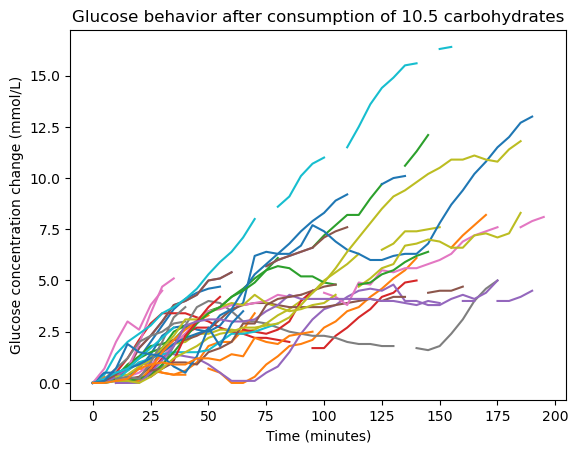

In [254]:
plot_aggregate(glucose_after_carbs_filtered, 'Glucose behavior after consumption of 10.5 carbohydrates')
plt.savefig(fname="Glucose behavior afer consumprion of 10,5 carbohydrates")

### Automatic processing of data

##### Processing data for aggregate plotting

Process data so that curves start from origin and are continuous to model change and make comparisons clear

In [21]:
np_gluc_auto = np.array(glucose_after_carbs_filtered, dtype=object)

In [22]:
glucose_series_fill = np_gluc_auto
i4 = 0

for val in np_gluc_auto:
    glucose_series_fill[i4] = pd.to_numeric(pd.Series(glucose_series_fill[i4]), errors='coerce').fillna(method='bfill')
    i4 += 1

In [23]:
glucose_series_auto = []
i5 = 0

for value in glucose_series_fill:
    glucose_series_auto.append(value - value[0]) #Make all values start from zero
    i5 += 1

Get glucose values ranging from lowest value after eating 10.5 carbohydrates to the first maximum to isolate the effect of carbohydrate consumption from later actions in the 3h interval

In [24]:
def get_glucose_min_first_max(l):
    
    i = 1
    
    result = []
    
    while l[i] >= l[i - 1]:
        result.append(l[i - 1])
        i += 1
        if i == len(l) or l[i] < l[i - 1]:
            result.append(l[i - 1])
            break
            
    return result

In [25]:
glucose_min_first_max_auto = [get_glucose_min_first_max(arr) for arr in glucose_series_auto]

Average time for glucose to reach maximum concentration after carbohydrate consumption

In [26]:
def get_avg_time_auto(list):
    
    i = 0
    lens = []
    
    for value in list:
        lens.append(len(list[i]))
        i += 1
    
    return np.mean(lens) * 5 # x5 to get minutes

In [27]:
avg_time_for_glucose_rise_auto = get_avg_time_auto(glucose_min_first_max_auto)
avg_time_for_glucose_rise_auto

60.78125

##### Calculating quartiles for duration

Quartiles are calculated to remove outliers and to reveal general information about the data 

In [28]:
glucose_rise_times = [len(i) * 5 for i in glucose_min_first_max_auto] # * 5 for minutes
glucose_rise_times.sort()
glucose_rise_times

[15,
 20,
 20,
 20,
 20,
 25,
 25,
 35,
 40,
 40,
 40,
 45,
 45,
 45,
 45,
 45,
 55,
 55,
 60,
 60,
 60,
 65,
 65,
 80,
 85,
 85,
 85,
 100,
 115,
 140,
 150,
 160]

Lower quartile Q<sub>1</sub> = $\frac{n + 1}{4}$th value  
<span style="font-size: 12px">(Decimals handled according to: https://brilliant.org/wiki/data-interquartile-range/: Q<sub>1</sub> = *n*th value + 0.dd $\times$ ((*n + 1*)th observation - *n*th observation)</span>

In [29]:
glucose_rise_times_q1 = glucose_rise_times[int((len(glucose_rise_times) + 1) * (1/4) - 1)] + ((((len(glucose_rise_times) + 1) * (1/4) - 1) % 1) * (glucose_rise_times[int((len(glucose_rise_times) + 1) * (1/4))] - glucose_rise_times[int((len(glucose_rise_times) + 1) * (1/4) - 1)])) # -1 to counter zero indexing
glucose_rise_times_q1

36.25

Median Q<sub>2</sub> = $\frac{n + 1}{2}$th value

In [30]:
glucose_rise_times_q2 = glucose_rise_times[int((len(glucose_rise_times) + 1) * (2/4) - 1)] + ((((len(glucose_rise_times) + 1) * (2/4) - 1) % 1) * (glucose_rise_times[int((len(glucose_rise_times) + 1) * (2/4))] - glucose_rise_times[int((len(glucose_rise_times) + 1) * (2/4) - 1)]))
glucose_rise_times_q2

50.0

Upper quartile Q<sub>3</sub> = $\frac{3n + 1}{4}$th value

In [31]:
glucose_rise_times_q3 = glucose_rise_times[int((len(glucose_rise_times) + 1) * (3/4) - 1)] + ((((len(glucose_rise_times) + 1) * (3/4) - 1) % 1) * (glucose_rise_times[int((len(glucose_rise_times) + 1) * (3/4))] - glucose_rise_times[int((len(glucose_rise_times) + 1) * (3/4) - 1)]))
glucose_rise_times_q3

83.75

Interquartile range IQR (Q<sub>3</sub> - Q<sub>1</sub>)

In [32]:
glucose_rise_times_IQR = glucose_rise_times_q3 - glucose_rise_times_q1
glucose_rise_times_IQR

47.5

Finding outliers

Upper limit

In [33]:
glucose_rise_times_IGQ_upper_limit = glucose_rise_times_q3 + 1.5 * glucose_rise_times_IQR
glucose_rise_times_IGQ_upper_limit

155.0

Lower limit

In [34]:
glucose_rise_times_IGQ_lower_limit = glucose_rise_times_q1 - 1.5 * glucose_rise_times_IQR
glucose_rise_times_IGQ_lower_limit

-35.0

Taking out outliers

In [35]:
glucose_rise_times_wo_outliers = []
glucose_rise_times_outliers = []

for i in glucose_rise_times:
    if i < glucose_rise_times_IGQ_upper_limit and i > glucose_rise_times_IGQ_lower_limit:
        glucose_rise_times_wo_outliers.append(i)
    else: 
        glucose_rise_times_outliers.append(i)
        
print(glucose_rise_times_wo_outliers)
print(glucose_rise_times_outliers)

[15, 20, 20, 20, 20, 25, 25, 35, 40, 40, 40, 45, 45, 45, 45, 45, 55, 55, 60, 60, 60, 65, 65, 80, 85, 85, 85, 100, 115, 140, 150]
[160]


In [36]:
glucose_series_auto_wo_time_outliers = []
    
for i in glucose_min_first_max_auto:
    if (len(i) * 5) not in glucose_rise_times_outliers:
        glucose_series_auto_wo_time_outliers.append(i)

Mean time

In [37]:
mean_time = stats.mean(glucose_rise_times_wo_outliers)
mean_time

57.58064516129032

Rounding mean time up for modeling

In [38]:
i9 = 0

if round(mean_time) % 5 == 0:
    mean_time_to_5 = round(mean_time)
else:
    while round(mean_time) % 5 != 0:
        mean_time_to_5 = round(mean_time) + i9
        i9 += 1
        if mean_time_to_5 % 5 == 0:
            break

In [39]:
mean_time_to_5

60

###### Statistical characteristics of the time data according to Pandas

In [40]:
glucose_rise_times_stats = pd.Series(glucose_rise_times)

In [41]:
glucose_rise_times_stats.describe()

count     32.000000
mean      60.781250
std       38.229135
min       15.000000
25%       38.750000
50%       50.000000
75%       81.250000
max      160.000000
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x2101ba3a3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x2101ba3aaf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2101ba3a040>],
 'medians': [<matplotlib.lines.Line2D at 0x2101ba4a250>],
 'fliers': [<matplotlib.lines.Line2D at 0x2101ba4a5e0>],
 'means': []}

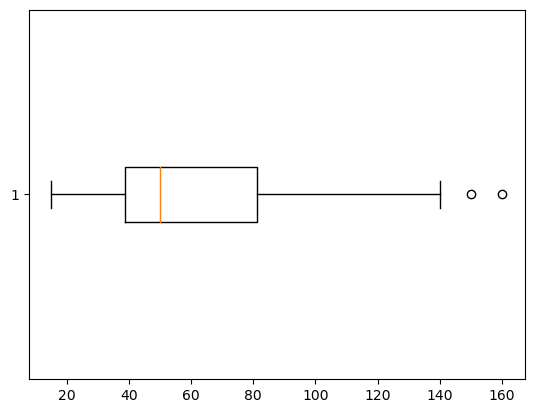

In [42]:
plt.boxplot(glucose_rise_times, vert=False) #matplotlib employes https://en.wikipedia.org/wiki/Quartile method 2

##### Calculating quartiles for end magnitude

Quartiles are calculated to remove outliers and to reveal general information about the data

Finding maximum value of each instance

In [43]:
glucose_rise_magnitudes = []
    
for i in glucose_min_first_max_auto: 
    glucose_rise_magnitudes.append(i[-1])
    
glucose_rise_magnitudes.sort()
glucose_rise_magnitudes

[0.10000000000000053,
 0.10000000000000053,
 0.2999999999999998,
 0.6999999999999997,
 1.0,
 1.0,
 1.0,
 1.3999999999999995,
 1.9000000000000004,
 2.6,
 2.7,
 2.7,
 2.8,
 2.8000000000000007,
 2.8999999999999995,
 3.0,
 3.0,
 3.0999999999999996,
 3.3999999999999995,
 3.8999999999999995,
 3.9000000000000004,
 4.0,
 4.2,
 4.299999999999999,
 4.7,
 5.1,
 5.699999999999999,
 6.6000000000000005,
 7.6000000000000005,
 10.1,
 12.100000000000001,
 16.400000000000002]

Lower quartile Q<sub>1</sub> = $\frac{n + 1}{4}$th value  
<span style="font-size: 12px">(Decimals handled according to: https://brilliant.org/wiki/data-interquartile-range/: Q<sub>1</sub> = *n*th value + 0.dd $\times$ ((*n + 1*)th observation - *n*th observation)</span>

In [44]:
glucose_rise_magnitudes_q1 = glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (1/4) - 1)] + ((((len(glucose_rise_magnitudes) + 1) * (1/4) - 1) % 1) * (glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (1/4))] - glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (1/4) - 1)])) # -1 to counter zero indexing
glucose_rise_magnitudes_q1

1.5249999999999997

Median Q<sub>2</sub> = $\frac{n + 1}{2}$th value

In [45]:
glucose_rise_magnitudes_q2 = glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (2/4) - 1)] + ((((len(glucose_rise_magnitudes) + 1) * (2/4) - 1) % 1) * (glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (2/4))] - glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (2/4) - 1)])) # -1 to counter zero indexing
glucose_rise_magnitudes_q2

3.0

Upper quartile Q<sub>3</sub> = $\frac{3(n + 1)}{4}$th value

In [46]:
glucose_rise_magnitudes_q3 = glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (3/4) - 1)] + ((((len(glucose_rise_magnitudes) + 1) * (3/4) - 1) % 1) * (glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (3/4))] - glucose_rise_magnitudes[int((len(glucose_rise_magnitudes) + 1) * (3/4) - 1)])) # -1 to counter zero indexing
glucose_rise_magnitudes_q3

4.6

Interquartile range IQR (Q<sub>3</sub> - Q<sub>1</sub>)

In [47]:
glucose_rise_magnitudes_IQR = glucose_rise_magnitudes_q3 - glucose_rise_magnitudes_q1
glucose_rise_magnitudes_IQR

3.075

Finding outliers

Upper limit

In [48]:
glucose_rise_magnitudes_IGQ_upper_limit = glucose_rise_magnitudes_q3 + 1.5 * glucose_rise_magnitudes_IQR
glucose_rise_magnitudes_IGQ_upper_limit

9.2125

Lower limit

In [49]:
glucose_rise_magnitudes_IGQ_lower_limit = glucose_rise_magnitudes_q1 - 1.5 * glucose_rise_magnitudes_IQR
glucose_rise_magnitudes_IGQ_lower_limit

-3.0875000000000012

In [50]:
glucose_rise_magnitudes_wo_outliers = []
glucose_rise_magnitudes_outliers = []

for i in glucose_rise_magnitudes:
    if i < glucose_rise_magnitudes_IGQ_upper_limit and i > glucose_rise_magnitudes_IGQ_lower_limit:
        glucose_rise_magnitudes_wo_outliers.append(i)
    else: 
        glucose_rise_magnitudes_outliers.append(i)
        
print('Magnitudes without outliers:', glucose_rise_magnitudes_wo_outliers)
print('Outliers:', glucose_rise_magnitudes_outliers)

Magnitudes without outliers: [0.10000000000000053, 0.10000000000000053, 0.2999999999999998, 0.6999999999999997, 1.0, 1.0, 1.0, 1.3999999999999995, 1.9000000000000004, 2.6, 2.7, 2.7, 2.8, 2.8000000000000007, 2.8999999999999995, 3.0, 3.0, 3.0999999999999996, 3.3999999999999995, 3.8999999999999995, 3.9000000000000004, 4.0, 4.2, 4.299999999999999, 4.7, 5.1, 5.699999999999999, 6.6000000000000005, 7.6000000000000005]
Outliers: [10.1, 12.100000000000001, 16.400000000000002]


In [51]:
glucose_series_auto_wo_magnitudes_outliers = []
    
for i in glucose_min_first_max_auto:
    if any(i) not in glucose_rise_magnitudes_outliers:
        glucose_series_auto_wo_magnitudes_outliers.append(i)

Mean magnitude

In [52]:
stats.mean(glucose_rise_magnitudes_wo_outliers)

2.9827586206896552

Glucose rise with no outliers

In [53]:
glucose_rise_wo_outliers = []
    
for i in glucose_min_first_max_auto:
    if (len(i) * 5) not in glucose_rise_times_outliers and i[-1] not in glucose_rise_magnitudes_outliers:
        glucose_rise_wo_outliers.append(i)

In [54]:
def extend_list_auto(l):

    rslt = []

    for val in l:
        if len(val) >= len(max(l, key=len)):
            rslt.append(val)
        if len(val) < len(max(l, key=len)):
            a = np.pad(val, (0, (len(max(l, key=len)) - len(val))), mode='edge')
            rslt.append(a)
    
    return rslt

In [55]:
glucose_after_carbs_extended_auto = extend_list_auto(glucose_rise_wo_outliers)

#### Visualizing the automatically processed data

##### Aggregate plot

Graph of all glucose increases as a result of 5 'Siripiri's (10.5 carbohydrates) with outliers removed

For the purposes of modeling, it is assumed that glucose concentration is constant before carbohydrate consumption and that it also settles on to a constant level after

The straight black lines in denote the means on each axis; the vertical one being the mean of duration and the horizontal being the mean of glucose concentration. At their intersections, they divide the graph into four rectangles of which the one enclosed by the mean lines and the axes will be the section modeled.

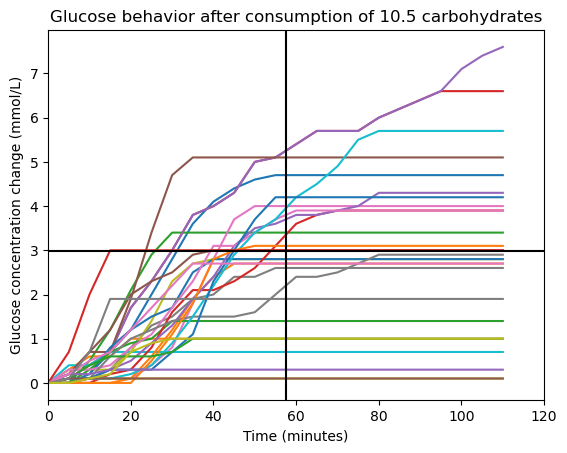

In [255]:
plot_aggregate(glucose_after_carbs_extended_auto, 'Glucose behavior after consumption of 10.5 carbohydrates')
plt.axhline(2.983, color="black")
plt.axvline(57.58, color="black")
plt.xlim(0, 120)
plt.savefig(fname='GLucose behavior carbohydrates with means')

##### Visualizing the average glucose curve after carbohydrate consumption

An average glucose curve after carbohydrate consumption is constructed by averaging all glucose rise magnitudes at every 5-minute interval up to mean duration with the assumption of constant, stable ends

In [57]:
avg_glucose_curve_auto = [np.mean([x[i] for x in glucose_after_carbs_extended_auto if len(x) > i]) for i in range(int(mean_time_to_5 / 5) + 1)]

In [58]:
avg_glucose_curve_auto

[0.0,
 0.13793103448275854,
 0.33448275862068955,
 0.6034482758620688,
 0.9344827586206896,
 1.2724137931034483,
 1.6551724137931034,
 2.027586206896552,
 2.2758620689655173,
 2.4482758620689653,
 2.596551724137931,
 2.6862068965517243,
 2.768965517241379]

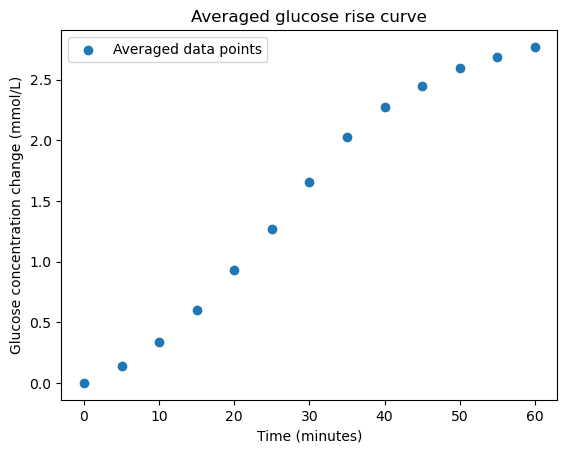

In [59]:
plt.scatter(x_domain[:len(avg_glucose_curve_auto)], avg_glucose_curve_auto)
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose concentration change (mmol/L)')
plt.title('Averaged glucose rise curve')
plt.legend(['Averaged data points'])
plt.savefig(fname='Avg glucose behavior carbohydrates')

##### Average graph with stable ends

Visualizing and making explicit the assumption of stable ends for ease of modeling distinct change (Automatic setting of start and end magnitudes by curve fit)

In [60]:
extended_avg_glucose_curve_auto = [value for value in avg_glucose_curve_auto]

extension_number = len(avg_glucose_curve_auto)
i11 = 0

while i11 < extension_number:
    extended_avg_glucose_curve_auto.insert(0, avg_glucose_curve_auto[0])
    extended_avg_glucose_curve_auto.insert(-1, avg_glucose_curve_auto[-1])
    i11 += 1


In [61]:
x_extended = np.arange(-1000, 1000, 5)

In [62]:
x_extended_range = x_extended[(200 - extension_number):(200 + len(extended_avg_glucose_curve_auto) - extension_number)]

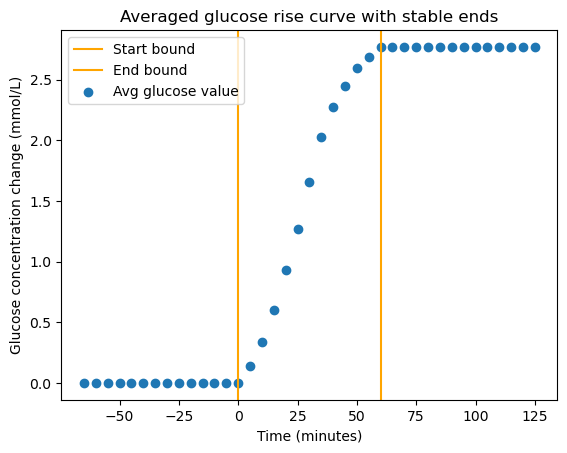

In [63]:
plt.scatter(x_extended_range, extended_avg_glucose_curve_auto)
plt.axvline(0, color='orange')
plt.axvline(mean_time_to_5, color='orange')
plt.legend(['Start bound', 'End bound', 'Avg glucose value'])
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose concentration change (mmol/L)')
plt.title('Averaged glucose rise curve with stable ends')
plt.savefig(fname='Avg glucose rise curve with stable ends')

##### Modeling the average glucose curve after carbohydrate consumption

###### Manual modeling with a logistic function: $\frac{L}{1 + e^{-k(x-x0)}}$

The logistic function is a special case of the generalized logistic function detailed below. It is a more simple sigmoid function that fulfills the requirements of stable ends (asymptotes) and the gradually changing rate of change that is at its peak midway through the transition, closely resembling the S-shape of the data. Its small number of parameters makes it easier to approximate manually. Its solved parameters work as relatively accurate and thus actionable guess values for the curve fitting of the generalized logistic function.

In [64]:
def logistic_function(x, L, k, x0):
    return L / (1 + np.exp(-k*(x-x0)))

Solving the parameters

L = the curve's maximum value

In [65]:
L = avg_glucose_curve_auto[-1]
L

2.768965517241379

Calculate gradients between all points

In [66]:
i20 = 0
slopes = []

while i20 < (len(avg_glucose_curve_auto) - 1):
    slopes.append((avg_glucose_curve_auto[i20 + 1] - avg_glucose_curve_auto[i20]) / 5) #all gradients in avg_glucose_curve_auto
    i20 += 1

In [67]:
x0_steepest = x_domain[slopes.index(max(slopes))] #steepest gradient
x0_steepest

25

x0 =  the x value of the sigmoid's midpoint

In [68]:
x0_midpoint = x_domain[math.floor(len(avg_glucose_curve_auto) / 2)]
x0_midpoint

30

k = the logistic growth rate or steepness of the curve.

In [69]:
k = (np.log((L / avg_glucose_curve_auto[2]) - 1) / 20)
k

0.09924521294949298

In [70]:
continuous_x_domain = np.linspace(-180, 180, (2*180*60*60))

Text(0, 0.5, 'Increase in glucose levels (mmol/L)')

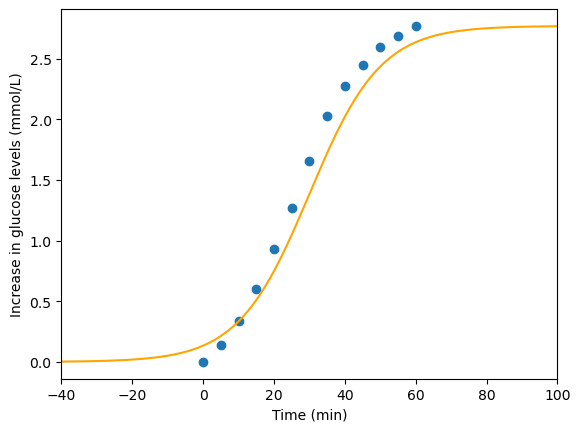

In [71]:
plt.plot(continuous_x_domain, logistic_function(continuous_x_domain, L, k, x0_midpoint), color="orange")
#plt.scatter(x_extended_range, extended_avg_glucose_curve_auto)
plt.scatter(x_domain[:len(avg_glucose_curve_auto)], avg_glucose_curve_auto)
plt.xlim(-40, 100)
plt.xlabel('Time (min)')
plt.ylabel('Increase in glucose levels (mmol/L)')

###### Modeling with the generalized logistic function $F(x) = A + \frac{K - A}{(C + Qe^{-B(x - M)})^{1/v}}$

Generalized logistic function is a sigmoid function that fulfills the requirements of stable ends (asymptotes) and the gradually changing rate of change that is at its peak midway through the transition, closely resembling the S-shape of the data.  
Richard's curve was originally developed for growth modeling, which makes it very fitting for modeling glucose concentration changes and the generalized version of the logistic function (that is the Richard's curve) offers the most flexibility for curve fitting due to its large number of parameters.

In [72]:
def generalized_logistic_function(x, A, K, C, Q, B, M, v):
    return A + ((K - A) / (C + Q * np.exp(-B*(x - M))) ** (1/v))

Defining variables for a continuos model curve

In [73]:
continuous_domain_glucose = np.linspace(x_extended_range[0], x_extended_range[-1], 100000)
continuous_range_glucose_function = interp1d(x_extended_range, extended_avg_glucose_curve_auto, "cubic")
continuous_range_glucose = continuous_range_glucose_function(continuous_domain_glucose)

Fitting the curve to the data to get optimal parameters for the model

In [74]:
gen_popt, gen_pcov = opt.curve_fit(generalized_logistic_function, continuous_domain_glucose, continuous_range_glucose, [0, L, 1, 1, k, x0_midpoint, 1])

C:\Users\Acer\AppData\Local\Temp/ipykernel_30044/3168972260.py:2: RuntimeWarning: overflow encountered in multiply
  return A + ((K - A) / (C + Q * np.exp(-B*(x - M))) ** (1/v))
C:\Users\Acer\AppData\Local\Temp/ipykernel_30044/3168972260.py:2: RuntimeWarning: invalid value encountered in power
  return A + ((K - A) / (C + Q * np.exp(-B*(x - M))) ** (1/v))


In [75]:
gen_popt

array([-8.13949398e-03,  2.79432122e+00,  1.00216468e+00,  5.22962804e-01,
        1.00561915e-01,  2.53934331e+01,  5.72357184e-01])

Plotting the fitted curve

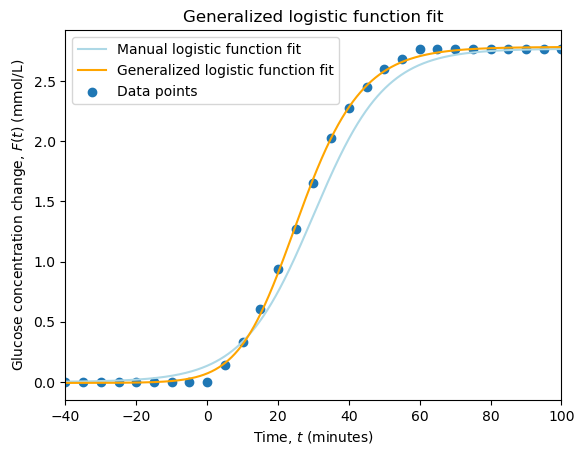

In [76]:
plt.plot(continuous_x_domain, logistic_function(continuous_x_domain, L, k, x0_midpoint), color="lightblue")
plt.plot(continuous_x_domain, generalized_logistic_function(continuous_x_domain, *gen_popt), color="orange")
plt.scatter(x_extended_range, extended_avg_glucose_curve_auto)
plt.xlim(-40, 100)
plt.xlabel('Time, $\it{t}$ (minutes)')
plt.ylabel('Glucose concentration change, $\it{F(t)}$ (mmol/L)')
plt.title('Generalized logistic function fit')
plt.legend(['Manual logistic function fit', 'Generalized logistic function fit', 'Data points'])
plt.savefig(fname='Generalized logistic function fit w manual')

## Modeling glucose levels after injection of 1 unit of insulin

##### Defining functions and processing data

A function to get the range of glucose values from maximum to minimum in a 3h interval based on a datetime input
> <span style="font-size: 12px">Call function with `get_glucose_maxmin(concise_data.loc[(slice(None), 'YYYY-MM-DDThh:mm:ss'), 'Timestamp (YYYY-MM-DDThh:mm:ss)'].values)`</span>  
> <span style="font-size: 10px">where Y = year, M = month, D = day, T = separator, h = hour, m = minute, s = second</span>

3h interval chosen based on both personal experience and official time of action data from Novo Nordisk (the manufacturer), which states that the dosage can be taken anywhere from the start of the meal to 20 minutes after beginning the meal. According to the data, peak effect is reached with all dosages and the insulin concentration has significantly decreased within this interval, while the effect of other variables are minimized. This is the factor dictating the magnitude of both intervals as they must be same for realistic comparison. Minimum to maximum approach as an assumption is a key weakness but one made to offset the effect of other variables such as prior "momentum" of the glucose levels and to make data more easy and clean to process, compare and model. 

In [77]:
def get_glucose_maxmin(date):
    from_date = tuple(date) #tuple to avoid unhashable type: 'Series' error
    date_format = pd.to_datetime(date) #format object to datetime
    from_date_add_3h = date_format + datetime.timedelta(hours=3) #add 3h to get right bound
    to_date_string = from_date_add_3h.strftime('%Y-%m-%dT%H:%M:%S') #convert to str
    to_date = tuple(to_date_string) #tuple to avoid unhashable type: 'Series' error
    date_3h_range = glucose_woI.loc[from_date:to_date]
    
    date_range_array = np.array(date_3h_range.reset_index(drop=True))
    max_index = np.where(date_range_array == max(date_range_array))
    min_index = np.where(date_range_array == min(date_range_array))
    max_index_int = int(max_index[0][0]) + 1
    min_index_int = int(min_index[0][0])
    
    return date_range_array[max_index_int:min_index_int]

Get all glucose ranges from maximum to minimum within 3 hours from the injection of 1 unit as the `glucose_after_insulin` list

In [78]:
glucose_after_insulin = get_range_list(fa_insulin_1u_timing, get_glucose_maxmin)

Filter out empty arrays

In [79]:
glucose_after_insulin_filtered = [e for e in glucose_after_insulin if e.size > 0]

Plot of every instance of glucose behavior after injection of 1 unit of insulin

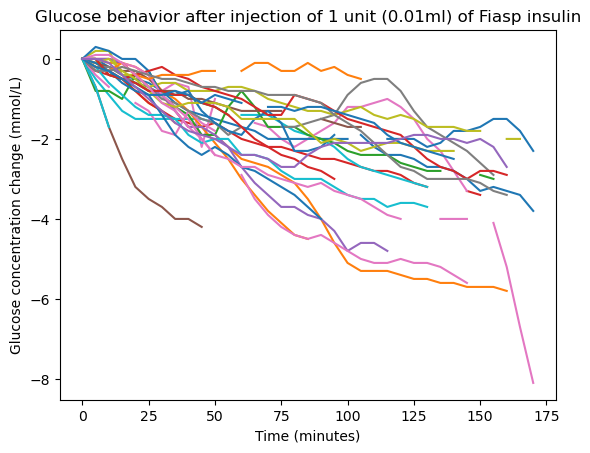

In [262]:
plot_aggregate(glucose_after_insulin_filtered, 'Glucose behavior after injection of 1 unit (0.01ml) of Fiasp insulin')
plt.savefig(fname="Glucose behavior afer injection of 1 unit of insulin")

### Automatic processing of data

##### Processing data for aggregate plotting

Process data so that curves start from origin and are continuous to model change and make comparisons clear

In [81]:
np_insulin_auto = np.array(glucose_after_insulin_filtered, dtype=object)

In [82]:
glucose_series_insulin_fill = np_insulin_auto
i8 = 0

for val in np_insulin_auto:
    glucose_series_insulin_fill[i8] = pd.to_numeric(pd.Series(glucose_series_insulin_fill[i8]), errors='coerce').fillna(method='bfill')
    i8 += 1

In [83]:
glucose_series_insulin = []
i7 = 0

for value in glucose_series_insulin_fill:
    glucose_series_insulin.append(value - value[0]) #Make all values start from zero
    i7 += 1

Get glucose values ranging from highest value after injecting one unit of insulin (0.03ml) to the first minimum to isolate the effect of insulin injection from later actions in the 3h interval

In [84]:
def get_glucose_max_first_min(l):
    
    i = 1
    
    result = []
    
    while l[i] <= l[i - 1]:
        result.append(l[i - 1])
        i += 1
        if i == len(l) or l[i] > l[i - 1]:
            result.append(l[i - 1])
            break
            
    return result

In [85]:
glucose_max_first_min_auto = [get_glucose_max_first_min(arr) for arr in glucose_series_insulin]

In [86]:
glucose_max_first_min = [e for e in glucose_max_first_min_auto if len(e) > 0]

Average time for glucose to reach minimum concentration after carbohydrate consumption

In [87]:
avg_time_for_glucose_drop_auto = get_avg_time_auto(glucose_max_first_min)
avg_time_for_glucose_drop_auto

54.06976744186046

##### Calculating quartiles for duration

Quartiles are calculated to remove outliers and to reveal general information about the data

In [88]:
glucose_drop_times = [len(i) * 5 for i in glucose_max_first_min] # * 5 for minutes
glucose_drop_times.sort()
glucose_drop_times

[10,
 10,
 15,
 15,
 15,
 15,
 15,
 15,
 20,
 20,
 20,
 20,
 20,
 20,
 25,
 30,
 30,
 35,
 35,
 40,
 50,
 50,
 50,
 50,
 50,
 55,
 55,
 60,
 60,
 75,
 80,
 85,
 90,
 90,
 90,
 90,
 90,
 100,
 105,
 110,
 110,
 135,
 170]

Lower quartile Q<sub>1</sub> = $\frac{n + 1}{4}$th value  
<span style="font-size: 12px">(Decimals handled according to: https://brilliant.org/wiki/data-interquartile-range/: Q<sub>1</sub> = *n*th value + 0.dd $\times$ ((*n + 1*)th observation - *n*th observation)</span>

In [89]:
glucose_drop_times_q1 = glucose_drop_times[int((len(glucose_drop_times) + 1) * (1/4) - 1)] + ((((len(glucose_drop_times) + 1) * (1/4) - 1) % 1) * (glucose_drop_times[int((len(glucose_rise_times) + 1) * (1/4))] - glucose_drop_times[int((len(glucose_drop_times) + 1) * (1/4) - 1)])) # -1 to counter zero indexing
glucose_drop_times_q1

20.0

Median Q<sub>2</sub> = $\frac{n + 1}{2}$th value

In [90]:
glucose_drop_times_q2 = glucose_drop_times[int((len(glucose_drop_times) + 1) * (2/4) - 1)] + ((((len(glucose_drop_times) + 1) * (2/4) - 1) % 1) * (glucose_drop_times[int((len(glucose_drop_times) + 1) * (2/4))] - glucose_drop_times[int((len(glucose_drop_times) + 1) * (2/4) - 1)]))
glucose_drop_times_q2

50.0

Upper quartile Q<sub>3</sub> = $\frac{3(n + 1)}{4}$th value

In [91]:
glucose_drop_times_q3 = glucose_drop_times[int((len(glucose_drop_times) + 1) * (3/4) - 1)] + ((((len(glucose_drop_times) + 1) * (3/4) - 1) % 1) * (glucose_drop_times[int((len(glucose_drop_times) + 1) * (3/4))] - glucose_drop_times[int((len(glucose_drop_times) + 1) * (3/4) - 1)]))
glucose_drop_times_q3

90.0

Interquartile range IQR (Q<sub>3</sub> - Q<sub>1</sub>)

In [92]:
glucose_drop_times_IQR = glucose_drop_times_q3 - glucose_drop_times_q1
glucose_drop_times_IQR

70.0

Finding outliers

Upper limit

In [93]:
glucose_drop_times_IGQ_upper_limit = glucose_drop_times_q3 + 1.5 * glucose_drop_times_IQR
glucose_drop_times_IGQ_upper_limit

195.0

Lower limit

In [94]:
glucose_drop_times_IGQ_lower_limit = glucose_drop_times_q1 - 1.5 * glucose_drop_times_IQR
glucose_drop_times_IGQ_lower_limit

-85.0

Taking out outliers

In [95]:
glucose_drop_times_wo_outliers = []
glucose_drop_times_outliers = []

for i in glucose_drop_times:
    if i < glucose_drop_times_IGQ_upper_limit and i > glucose_drop_times_IGQ_lower_limit:
        glucose_drop_times_wo_outliers.append(i)
    else: 
        glucose_drop_times_outliers.append(i)
        
print(glucose_drop_times_wo_outliers)
print(glucose_drop_times_outliers)

[10, 10, 15, 15, 15, 15, 15, 15, 20, 20, 20, 20, 20, 20, 25, 30, 30, 35, 35, 40, 50, 50, 50, 50, 50, 55, 55, 60, 60, 75, 80, 85, 90, 90, 90, 90, 90, 100, 105, 110, 110, 135, 170]
[]


In [96]:
glucose_series_insulin_wo_time_outliers = []
    
for i in glucose_max_first_min_auto:
    if (len(i) * 5) not in glucose_drop_times_outliers:
        glucose_series_insulin_wo_time_outliers.append(i)

Mean time

In [97]:
mean_time_insulin = stats.mean(glucose_drop_times_wo_outliers)
mean_time_insulin

54.06976744186046

Rounding mean time up for modeling

In [98]:
i10 = 0

if round(mean_time_insulin) % 5 == 0:
    mean_time_insulin_to_5 = round(mean_time_insulin)
else:
    while round(mean_time_insulin) % 5 != 0:
        mean_time_insulin_to_5 = round(mean_time_insulin) + i10
        i10 += 1
        if mean_time_insulin_to_5 % 5 == 0:
            break

In [99]:
mean_time_insulin_to_5

55

###### Statistical characteristics of the time data according to Pandas

In [100]:
glucose_drop_times_stats = pd.Series(glucose_drop_times)

In [101]:
glucose_drop_times_stats.describe()

count     43.000000
mean      54.069767
std       38.595210
min       10.000000
25%       20.000000
50%       50.000000
75%       87.500000
max      170.000000
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x2101c2fd1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x2101c2fd8b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2101c2e9df0>],
 'medians': [<matplotlib.lines.Line2D at 0x2101c2fdfd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2101c3133a0>],
 'means': []}

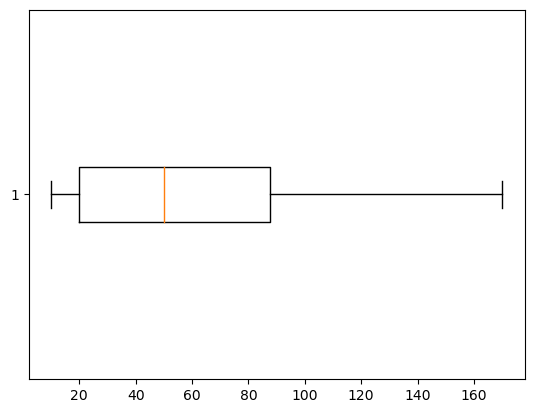

In [102]:
plt.boxplot(glucose_drop_times, vert=False) #matplotlib employes https://en.wikipedia.org/wiki/Quartile method 2

##### Calculating quartiles for end magnitude

Quartiles are calculated to remove outliers and to reveal general information about the data

Finding minimum value of each instance (maximum effect of insulin)

In [103]:
glucose_drop_magnitudes = []
    
for i in glucose_max_first_min: 
    glucose_drop_magnitudes.append(i[-1])
    
glucose_drop_magnitudes.sort()
glucose_drop_magnitudes

[-7.6000000000000005,
 -6.0,
 -5.7,
 -4.9,
 -4.800000000000001,
 -4.5,
 -4.5,
 -4.4,
 -4.2,
 -4.199999999999999,
 -3.5,
 -3.1999999999999993,
 -3.0,
 -2.6999999999999993,
 -2.4000000000000004,
 -2.2,
 -2.0999999999999996,
 -1.9000000000000004,
 -1.9000000000000004,
 -1.7999999999999998,
 -1.7000000000000002,
 -1.7000000000000002,
 -1.6999999999999993,
 -1.6999999999999993,
 -1.6999999999999993,
 -1.5999999999999996,
 -1.4000000000000004,
 -1.3999999999999995,
 -1.0,
 -0.9000000000000004,
 -0.7999999999999989,
 -0.7000000000000011,
 -0.5,
 -0.40000000000000036,
 -0.3000000000000007,
 -0.3000000000000007,
 -0.29999999999999893,
 -0.09999999999999964,
 -0.09999999999999964,
 -0.09999999999999964,
 -0.09999999999999964,
 0.0,
 0.0]

Lower quartile Q<sub>1</sub> = $\frac{n + 1}{4}$th value  
<span style="font-size: 12px">(Decimals handled according to: https://brilliant.org/wiki/data-interquartile-range/: Q<sub>1</sub> = *n*th value + 0.dd $\times$ ((*n + 1*)th observation - *n*th observation)</span>

In [104]:
glucose_drop_magnitudes_q1 = glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (1/4) - 1)] + ((((len(glucose_drop_magnitudes) + 1) * (1/4) - 1) % 1) * (glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (1/4))] - glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (1/4) - 1)])) # -1 to counter zero indexing
glucose_drop_magnitudes_q1

-3.5

Median Q<sub>2</sub> = $\frac{n + 1}{2}$th value

In [105]:
glucose_drop_magnitudes_q2 = glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (2/4) - 1)] + ((((len(glucose_drop_magnitudes) + 1) * (2/4) - 1) % 1) * (glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (2/4))] - glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (2/4) - 1)])) # -1 to counter zero indexing
glucose_drop_magnitudes_q2

-1.7000000000000002

Upper quartile Q<sub>3</sub> = $\frac{3n + 1}{4}$th value

In [106]:
glucose_drop_magnitudes_q3 = glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (3/4) - 1)] + ((((len(glucose_drop_magnitudes) + 1) * (3/4) - 1) % 1) * (glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (3/4))] - glucose_drop_magnitudes[int((len(glucose_drop_magnitudes) + 1) * (3/4) - 1)])) # -1 to counter zero indexing
glucose_drop_magnitudes_q3

-0.5

Interquartile range IQR (Q<sub>3</sub> - Q<sub>1</sub>)

In [107]:
glucose_drop_magnitudes_IQR = glucose_drop_magnitudes_q3 - glucose_drop_magnitudes_q1
glucose_drop_magnitudes_IQR

3.0

Finding outliers

Upper limit

In [108]:
glucose_drop_magnitudes_IGQ_upper_limit = glucose_drop_magnitudes_q3 + 1.5 * glucose_drop_magnitudes_IQR
glucose_drop_magnitudes_IGQ_upper_limit

4.0

Lower limit

In [109]:
glucose_drop_magnitudes_IGQ_lower_limit = glucose_drop_magnitudes_q1 - 1.5 * glucose_drop_magnitudes_IQR
glucose_drop_magnitudes_IGQ_lower_limit

-8.0

In [110]:
glucose_drop_magnitudes_wo_outliers = []
glucose_drop_magnitudes_outliers = []

for i in glucose_drop_magnitudes:
    if i < glucose_drop_magnitudes_IGQ_upper_limit and i > glucose_drop_magnitudes_IGQ_lower_limit:
        glucose_drop_magnitudes_wo_outliers.append(i)
    else: 
        glucose_drop_magnitudes_outliers.append(i)
        
print('Magnitudes without outliers:', glucose_drop_magnitudes_wo_outliers)
print('Outliers:', glucose_drop_magnitudes_outliers)

Magnitudes without outliers: [-7.6000000000000005, -6.0, -5.7, -4.9, -4.800000000000001, -4.5, -4.5, -4.4, -4.2, -4.199999999999999, -3.5, -3.1999999999999993, -3.0, -2.6999999999999993, -2.4000000000000004, -2.2, -2.0999999999999996, -1.9000000000000004, -1.9000000000000004, -1.7999999999999998, -1.7000000000000002, -1.7000000000000002, -1.6999999999999993, -1.6999999999999993, -1.6999999999999993, -1.5999999999999996, -1.4000000000000004, -1.3999999999999995, -1.0, -0.9000000000000004, -0.7999999999999989, -0.7000000000000011, -0.5, -0.40000000000000036, -0.3000000000000007, -0.3000000000000007, -0.29999999999999893, -0.09999999999999964, -0.09999999999999964, -0.09999999999999964, -0.09999999999999964, 0.0, 0.0]
Outliers: []


In [111]:
glucose_series_insulin_wo_magnitudes_outliers = []
    
for i in glucose_max_first_min:
    if any(i) not in glucose_drop_magnitudes_outliers:
        glucose_series_insulin_wo_magnitudes_outliers.append(i)

Mean magnitude

In [112]:
stats.mean(glucose_drop_magnitudes_wo_outliers)

-2.186046511627907

Glucose rise with no outliers

In [113]:
glucose_drop_wo_outliers = []
    
for i in glucose_max_first_min:
    if (len(i) * 5) not in glucose_drop_times_outliers and i[-1] not in glucose_drop_magnitudes_outliers:
        glucose_drop_wo_outliers.append(i)

In [114]:
def extend_list_auto(l):

    rslt = []

    for val in l:
        if len(val) >= len(max(l, key=len)):
            rslt.append(val)
        if len(val) < len(max(l, key=len)):
            a = np.pad(val, (0, (len(max(l, key=len)) - len(val))), mode='edge')
            rslt.append(a)
    
    return rslt

In [115]:
glucose_after_insulin_extended_auto = extend_list_auto(glucose_drop_wo_outliers)

#### Visualizing the automatically processed data

##### Aggregate plot

Graph of all glucose increases as a result of 1 unit of insulin with outliers removed

For the purposes of modeling, it is assumed that glucose concentration is constant before carbohydrate consumption and that it also settles on to a constant level after

The straight black lines in denote the means on each axis; the vertical one being the mean of duration and the horizontal being the mean of glucose concentration. At their intersections, they divide the graph into four rectangles of which the one enclosed by the mean lines and the axes will be the section modeled.

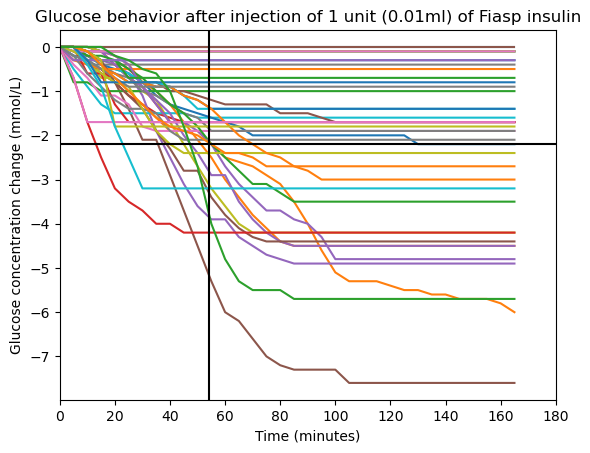

In [257]:
plot_aggregate(glucose_after_insulin_extended_auto, 'Glucose behavior after injection of 1 unit (0.01ml) of Fiasp insulin')
plt.axhline(-2.186, color="black")
plt.axvline(54.07, color="black")
plt.xlim(0, 180)
plt.savefig(fname='GLucose behavior insulin with means')

##### Visualizing the average glucose curve after insulin injection

An average glucose curve after insulin injection is constructed by averaging all glucose rise magnitudes at every 5-minute interval up to mean duration with the assumption of constant, stable ends

In [117]:
avg_glucose_curve_insulin = [np.mean([x[i] for x in glucose_after_insulin_extended_auto if len(x) > i]) for i in range(int(mean_time_insulin_to_5 / 5) + 1)]

In [118]:
avg_glucose_curve_insulin

[0.0,
 -0.127906976744186,
 -0.32790697674418595,
 -0.4930232558139534,
 -0.6790697674418603,
 -0.8418604651162788,
 -1.0,
 -1.1302325581395352,
 -1.2790697674418603,
 -1.4186046511627908,
 -1.5348837209302326,
 -1.686046511627907]

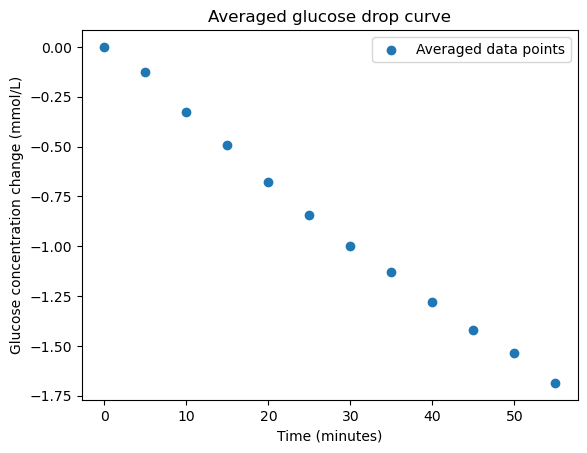

In [119]:
plt.scatter(x_domain[:len(avg_glucose_curve_insulin)], avg_glucose_curve_insulin)
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose concentration change (mmol/L)')
plt.title('Averaged glucose drop curve')
plt.legend(['Averaged data points'])
plt.savefig(fname='Avg glucose behavior insulin')

##### Average graph with stable ends

Visualizing and making explicit the assumption of stable ends for ease of modeling distinct change (Automatic setting of start and end magnitudes by curve fit)

In [120]:
extended_avg_glucose_curve_insulin = [value for value in avg_glucose_curve_insulin]

extension_number_insulin = len(avg_glucose_curve_insulin)
i12 = 0

while i12 < extension_number_insulin:
    extended_avg_glucose_curve_insulin.insert(0, avg_glucose_curve_insulin[0])
    extended_avg_glucose_curve_insulin.insert(-1, avg_glucose_curve_insulin[-1])
    i12 += 1


In [121]:
x_extended_range_insulin = x_extended[(200 - extension_number_insulin):(200 + len(extended_avg_glucose_curve_insulin) - extension_number_insulin)]

In [122]:
x_extended_range_insulin

array([-60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10,  -5,   0,
         5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115])

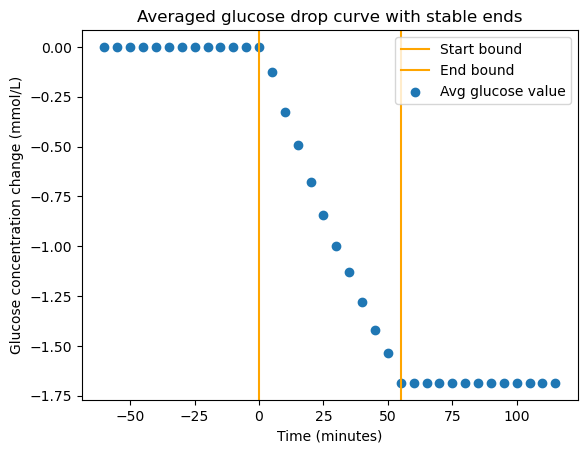

In [123]:
plt.scatter(x_extended_range_insulin, extended_avg_glucose_curve_insulin)
plt.axvline(0, color='orange')
plt.axvline(mean_time_insulin_to_5, color='orange')
plt.legend(['Start bound', 'End bound', 'Avg glucose value'])
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose concentration change (mmol/L)')
plt.title('Averaged glucose drop curve with stable ends')
plt.savefig(fname='Avg glucose drop curve with stable ends')

##### Modeling the average glucose curve after carbohydrate consumption

###### Manual modeling with a piecewise linear function
$$ G(x)=   \left\{
\begin{array}{ll}
      a(t - t_tr) + b & t<t_0 \\
      c(t - t_tr) + d & t_0 \ge t < t_1 \\
      e(t - t_tr) + h & t > t_1 \\
\end{array} 
\right.  $$

The data for insulin injection appears to be linearly decreasing, following a downward sloping line and so implying a linear function. This, however, cannot satisfy the assumption of stable ends as it would continue indefinitely. The model must start and end on discrete levels, which can be achieved by either a sigmoid function or a piecewise fuction, which enables the defining of different functions for different domain intervals. Choosing the latter offers the greatest amount of flexibility and enables modeling the change with a linear function, keeping the stable ends. This way the change is clearly defined.

In [124]:
def manual_piecewise_linear(t, t0, t1, t_trans, a, b, c, d, e, h):
    condlist = [(t - t_trans) < t0, ((t - t_trans) >= t0) & ((t - t_trans) < t1), (t - t_trans) >= t1]
    funclist = [lambda t: a*(t - t_trans) + b, lambda t: c*(t - t_trans) + d, lambda t: e*(t - t_trans) + h]
    return np.piecewise(t, condlist, funclist)

In [265]:
t0 = 0 #1st breakpoint
t1 = mean_time_insulin_to_5 #2nd breakpoint
t_trans = 0 #transformation parameter
a = 0 #slope of sub-function 1
b = 0 #y-intercept of sub-function 1
c = (avg_glucose_curve_insulin[-1] - avg_glucose_curve_insulin[0]) / mean_time_insulin_to_5 #slope of sub-function 2
d = 0 #y-intercept of sub-function 2
e = 0 #slope of sub-function 3
h = avg_glucose_curve_insulin[-1] #y-intercept of sub-function 3

Plotting the manual piecewise linear model

In [126]:
continuous_domain_insulin = np.linspace(x_extended_range_insulin[0], x_extended_range_insulin[-1], 100000)
continuous_range_insulin_function = interp1d(x_extended_range_insulin, extended_avg_glucose_curve_insulin, "linear")
continuous_range_insulin = continuous_range_insulin_function(continuous_domain_insulin)

(-40.0, 100.0)

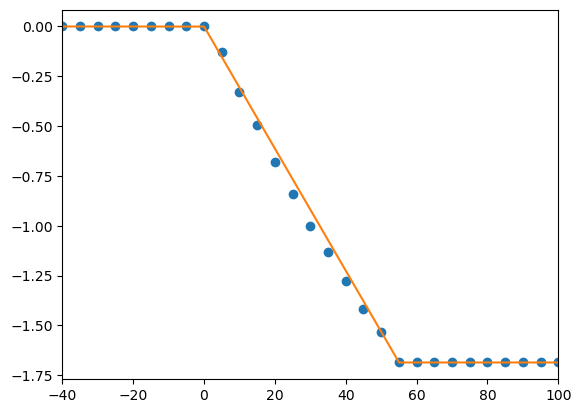

In [127]:
plt.plot(x_extended_range_insulin, extended_avg_glucose_curve_insulin, "o")
plt.plot(continuous_domain_insulin, manual_piecewise_linear(continuous_domain_insulin, t0, t1, t_trans, a, b, c, d, e, h))
plt.xlim(-40, 100)

Completing the curve fit by estimating `t_trans` and `c`

In [128]:
def fit_piecewise_linear(t, t_trans, c):
    condlist = [(t - t_trans) < t0, ((t - t_trans) >= t0) & ((t - t_trans) < t1), (t - t_trans) >= t1]
    funclist = [lambda t: a*(t - t_trans) + b, lambda t: c*(t - t_trans) + d, lambda t: e*(t - t_trans) + h]
    return np.piecewise(t, condlist, funclist)

In [129]:
popt_insulin, pcov_insulin = opt.curve_fit(fit_piecewise_linear, continuous_domain_insulin, continuous_range_insulin, [t_trans, c])

In [130]:
popt_insulin

array([-0.79560825, -0.03111161])

In [131]:
t1_new = t1 + popt_insulin[0]

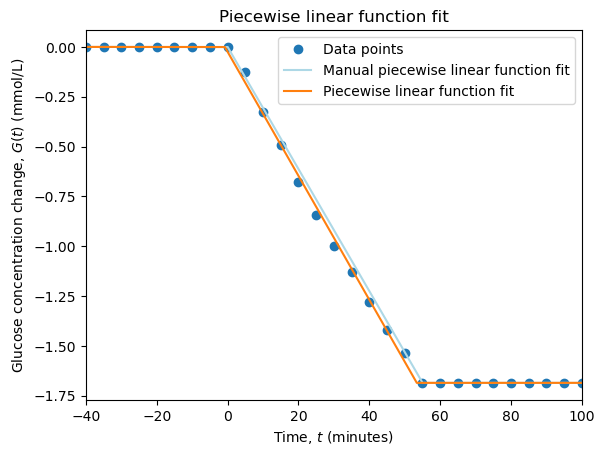

In [267]:
plt.plot(x_extended_range_insulin, extended_avg_glucose_curve_insulin, "o")
plt.plot(continuous_domain_insulin, manual_piecewise_linear(continuous_domain_insulin, t0, t1, t_trans, a, b, c, d, e, h), color="lightblue")
plt.plot(continuous_domain_insulin, manual_piecewise_linear(continuous_domain_insulin, t0, t1_new, popt_insulin[0], a, b, popt_insulin[1], d, e, h))
plt.xlim(-40, 100)
plt.xlabel('Time, $\it{t}$ (minutes)')
plt.ylabel('Glucose concentration change, $\it{G(t)}$ (mmol/L)')
plt.title('Piecewise linear function fit')
plt.legend(['Data points', 'Manual piecewise linear function fit', 'Piecewise linear function fit'])
plt.savefig(fname='piecewise linear fit')

## Calculating optimal timing based on models

Setting the x-axis scale to allow the examination of all relevant x-transformations

In [133]:
domain = np.linspace(-(mean_time_to_5 + mean_time_insulin_to_5*2), mean_time_to_5 + mean_time_insulin_to_5*2, 2*(mean_time_to_5 + mean_time_insulin_to_5)*60)

x-transformation parameter

In [134]:
x_trans = [t0, t1_new, a, b, popt_insulin[1], d, e, h]
x_trans.append(0) #Horizontal shift
x_trans

[0,
 54.20439174954004,
 0,
 0,
 -0.031111607516192213,
 0,
 0,
 -1.686046511627907,
 0]

Piecewise linear function with an x-transformation parameter

In [135]:
def piecewise_linear_trans(x, x0, x1, a, b, c, d, e, h, x_trans):
    condlist = [(x + x_trans) < x0, ((x + x_trans) >= x0) & ((x + x_trans) < x1), (x + x_trans) >= x1]
    funclist = [lambda x: a*(x + x_trans) + b, lambda x: c*(x + x_trans) + d, lambda x: e*(x + x_trans) + h]
    return np.piecewise(x, condlist, funclist)

Combined function

In [136]:
combined_function = generalized_logistic_function(domain, *gen_popt) + piecewise_linear_trans(domain, *x_trans) - gen_popt[0]

Area under the combined function

Definite integral start value

In [137]:
integral_start = -(mean_time_to_5 + mean_time_insulin_to_5)
integral_start

-115

Definite integral end value

In [138]:
integral_end = mean_time_to_5 + mean_time_insulin_to_5
integral_end

115

Definite integral of the combined function F(x) + G(x)

$\int\limits_{-115}^{115} F(x) + G(x)dx$

$\int\limits_{-115}^{115} A + \frac{K - A}{(C + Qe^{-Bt})^{1/v}} + \left\{
\begin{array}{ll}
      a(t - t_tr) + b & t<t_0 \\
      c(t - t_tr) + d & t_0 \ge t < t_1 \\
      e(t - t_tr) + h & t > t_1 \\
\end{array} 
\right.  $

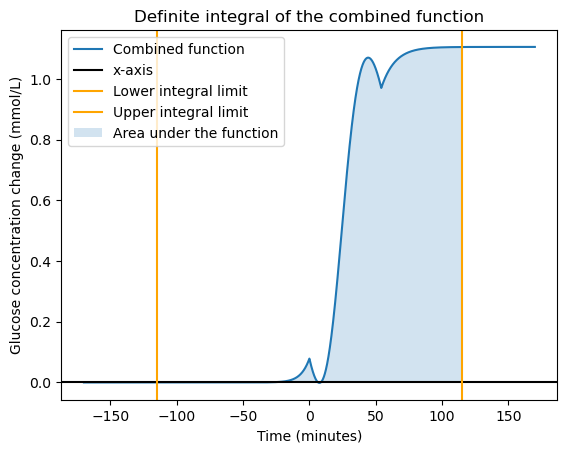

In [258]:
plt.plot(domain, combined_function)
plt.axhline(color="black")
plt.fill_between(domain, combined_function, where = [(x > integral_start) and (x < integral_end) for x in domain], alpha=0.2)
plt.axvline(integral_start, color="orange")
plt.axvline(integral_end, color="orange")
plt.legend(['Combined function', 'x-axis', 'Lower integral limit', 'Upper integral limit', 'Area under the function'])
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose concentration change (mmol/L)')
plt.title('Definite integral of the combined function')
plt.savefig(fname='Definite integral of the combined function')

#### Area under combined function (Symbolic method (slow))

Symbols used

In [140]:
x, A, K, C, Q, B, M, v, t0, t1, a, b, c, d, e, h = sy.symbols('x, A, K, C, Q, B, M, v, t0, t1, a, b, c, d, e, h')

Area under `generalized_logistic_function`

In [164]:
symbolic_generalized_logistic_function = A + ((K - A) / (C + Q * sy.exp(-B*(x - M))) ** (1/v))
symbolic_generalized_logistic_function

A + (-A + K)/(C + Q*exp(-B*(-M + x)))**(1/v)

Generalized logistic function with optimized parameter values

In [142]:
generalized_logistic_function_w_values = symbolic_generalized_logistic_function.subs({A:gen_popt[0], K:gen_popt[1], C:gen_popt[2], Q:gen_popt[3], B:gen_popt[4], M:gen_popt[5], v:gen_popt[6]})
generalized_logistic_function_w_values

0.100410838162034/(0.149090020570499 + exp(-0.100561915353152*x))**1.74716073770267 - 0.00813949398097104

In [143]:
generalized_logistic_function_integral = sy.integrate(abs(generalized_logistic_function_w_values), (x, integral_start, integral_end))
generalized_logistic_function_area = generalized_logistic_function_integral.evalf()
generalized_logistic_function_area

245.1

Area under `piecewise_linear`

In [144]:
x_transformation = sy.Symbol('x_trans')

In [145]:
symbolic_piecewise_linear = sy.Piecewise((a*(x + x_transformation) + b, (x + x_transformation) < t0), (c*(x + x_transformation) + d, sy.And((x + x_transformation) >= t0, (x + x_transformation) < t1)), (e*(x + x_transformation) + h, (x + x_transformation) >= t1))
symbolic_piecewise_linear

Piecewise((a*(x + x_trans) + b, t0 > x + x_trans), (c*(x + x_trans) + d, t1 > x + x_trans), (e*(x + x_trans) + h, True))

Piecewise linear function with optimized parameter values

In [146]:
piecewise_linear_w_values = symbolic_piecewise_linear.subs({t0:x_trans[0], t1:x_trans[1], a:x_trans[2], b:x_trans[3], c:x_trans[4], d:x_trans[5], e:x_trans[6], h:x_trans[7], x_transformation:x_trans[8]})
piecewise_linear_w_values

Piecewise((0, x < 0), (-0.0311116075161922*x, x < 54.20439174954), (-1.68604651162791, True))

In [147]:
piecewise_linear_area = sy.integrate(abs(piecewise_linear_w_values), (x, integral_start, integral_end))
piecewise_linear_area

148.208980448780

Area under the combined curve

In [148]:
co_fu = generalized_logistic_function_w_values + piecewise_linear_w_values
co_fu

0.100410838162034/(0.149090020570499 + exp(-0.100561915353152*x))**1.74716073770267 + Piecewise((0, x < 0), (-0.0311116075161922*x, x < 54.20439174954), (-1.68604651162791, True)) - 0.00813949398097104

In [149]:
area_under_combined_curve = generalized_logistic_function_area - piecewise_linear_area
area_under_combined_curve

96.8652383012202

#### Area under combined function (Numerical method (faster))

In [150]:
combined_function_w_values = generalized_logistic_function_w_values + piecewise_linear_w_values
combined_function_defined_parameters = sy.lambdify(x, combined_function_w_values)

Text(0.5, 1.0, 'Definite integral of the combined function')

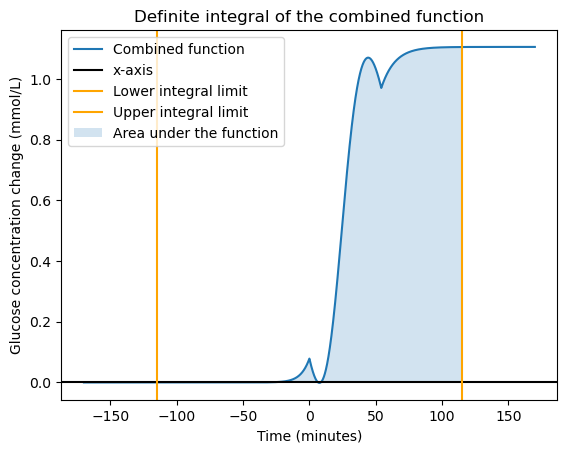

In [259]:
plt.plot(domain, combined_function_defined_parameters(domain) - gen_popt[0])
plt.axhline(color="black")
plt.fill_between(domain, combined_function, where = [(x > integral_start) and (x < integral_end) for x in domain], alpha=0.2)
plt.axvline(integral_start, color="orange")
plt.axvline(integral_end, color="orange")
plt.legend(['Combined function', 'x-axis', 'Lower integral limit', 'Upper integral limit', 'Area under the function'])
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose concentration change (mmol/L)')
plt.title('Definite integral of the combined function')

In [152]:
combined_function_area = integrate.quad(lambda x: abs(combined_function_defined_parameters(x)), integral_start, integral_end)
combined_function_area

(96.92766759393211, 1.2990572315629834e-06)

Compute all possible x-transformations within the domain

In [153]:
i12 = 0
list_of_x_trans = []
while i12 < len(domain):
    x_transf = [x_trans[0], x_trans[1], x_trans[2], x_trans[3], x_trans[4], x_trans[5], x_trans[6], x_trans[7], domain[i12]]
    list_of_x_trans.append(x_transf)
    i12 += 1

Compute linear piecewise function with all x-transformations

In [154]:
plwtv = []
i13 = 0

while i13 < len(list_of_x_trans):
    piecewise_linear_w_trans_values = symbolic_piecewise_linear.subs({t0:x_trans[0], t1:x_trans[1], a:x_trans[2], b:x_trans[3], c:x_trans[4], d:x_trans[5], e:x_trans[6], h:x_trans[7], x_transformation:list_of_x_trans[i13][8]})
    plwtv.append(piecewise_linear_w_trans_values)
    i13 += 1

Combine the generalized logistic function with linear piecewise function for each x-transformation

In [155]:
comb_funcs = []
i14 = 0

while i14 < len(plwtv):
    comb_funcs.append(sy.lambdify(x, (generalized_logistic_function_w_values + plwtv[i14])))
    i14 += 1

Integrate the combined function to get the definite integral, area, for each x-transformation

In [156]:
areas = []
i15 = 0

while i15 < len(comb_funcs):
    areas.append(integrate.quad(lambda x: abs(comb_funcs[i15](x)), integral_start, integral_end, limit=100))
    i15 += 1

C:\Users\Acer\AppData\Local\Temp/ipykernel_30044/569309330.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas.append(integrate.quad(lambda x: abs(comb_funcs[i15](x)), integral_start, integral_end, limit=100))


Display areas only without error assesment

In [157]:
areas_only = []
i16 = 0

while i16 < len(areas):
    areas_only.append(areas[i16][0])
    i16 += 1

## The glucose variability minimizing x-transformation

Graph of definite integral (area) of the combined function against the x-transformation of the linear piecewise function

Text(0, 0.5, 'Total area, $\\int_{-115}^{115} |F(x) + G(x) dx|$ under the combined curve')

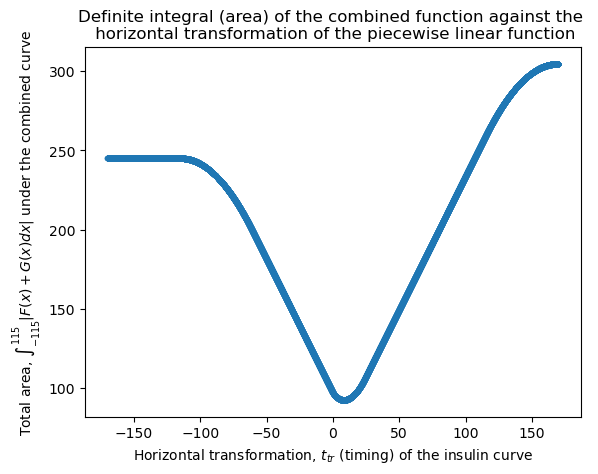

In [173]:
plt.plot(domain, areas_only, '.')
plt.title('Definite integral (area) of the combined function against the \n horizontal transformation of the piecewise linear function')
plt.xlabel('Horizontal transformation, $t_{tr}$ (timing) of the insulin curve')
plt.ylabel('Total area, $\int_{-115}^{115} |F(x) + G(x) dx|$ under the combined curve')
#plt.savefig(fname="Area vs horizontal transformation")
#plt.xlim(-50, 50)

This could most likely be modeled by either some piecewise function or by an asymmetric gaussian function achieved by combining a gaussian function with a logistic function $( ae^{-\frac{(x-b)^2}{2c^2}} + \frac{L}{1 + e^{-k(x-x0)}} )$ which could then be differentiated in terms of x to find the minimum ($\frac{dy}{dx} = 0$ AND $\frac{d^2x}{dx^2} = +$) but doing this with the dataset generated would not make much sense as the modeling itself would require knowing the minimum point, unless a function looking like this could be derived directly from the combined function to be integrated.

The glucose variability minimizing x-transformation

In [159]:
area_minimizing_transformation = domain[areas_only.index(min(areas_only))]
area_minimizing_transformation

8.192622653815505

If the value is positive, it refers to minutes before carbohydrate consumption; if negative, it refers to -(minutes after carbohydrate consumption)

Area before and after x-transformation

In [160]:
x_trans_opt = [i for i in x_trans]
x_trans_opt[-1] = (domain[areas_only.index(min(areas_only))])
x_trans_opt

[0,
 54.20439174954004,
 0,
 0,
 -0.031111607516192213,
 0,
 0,
 -1.686046511627907,
 8.192622653815505]

In [161]:
combined_function_2 = generalized_logistic_function(domain, *gen_popt) + piecewise_linear_trans(domain, *x_trans_opt) - gen_popt[0]

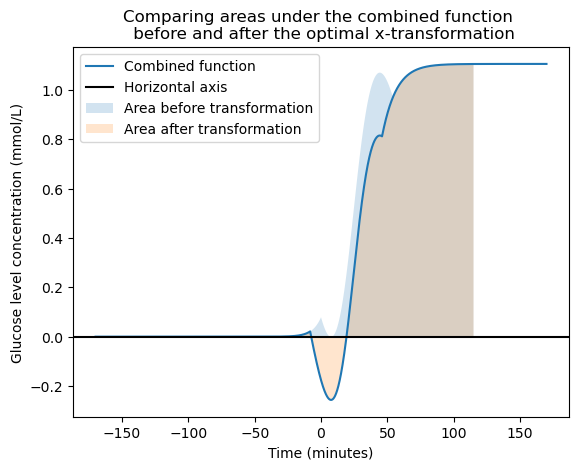

In [260]:
plt.plot(domain, combined_function_2)
plt.axhline(color="black")
plt.fill_between(domain, combined_function, where = [(x > integral_start) and (x < integral_end) for x in domain], alpha=0.2)
plt.fill_between(domain, combined_function_2, where = [(x > integral_start) and (x < integral_end) for x in domain], alpha=0.2)
plt.legend(['Combined function', 'Horizontal axis', 'Area before transformation', 'Area after transformation'])
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose level concentration (mmol/L)')
plt.title('Comparing areas under the combined function \n before and after the optimal x-transformation')
plt.savefig(fname="Areas comparison")

The absolute area under the combined curve can be used as a proxy for glucose variability, in this case defined as any change in concentration, as it is a measure of absolute divergence from zero over time, giving a single, easily comparable number involving both the magnitude and time of glucose concentration change. By comparing the area under the combined curve as a result of each x-transformation of the insulin curve, the optimal timing can be found as the absolute value of the x-transformation bringing about the smallest definite integral. If the value inside the absolute value is positive, it is before eating and if negative, after eating.

The optimal timing for insulin injection to minimize glucose level variability after a meal in ideal conditions:

In [163]:
if area_minimizing_transformation < 0:
    print(f"{abs(area_minimizing_transformation):.0f} minutes {((abs(area_minimizing_transformation) % 1)*60):.0f} after starting to eat")
elif area_minimizing_transformation == 0:
    print("At the same time when starting to eat")
else:
    print(F"{abs(area_minimizing_transformation):.0f} minutes {((abs(area_minimizing_transformation) % 1)*60):.0f} seconds before starting to eat")

8 minutes 12 seconds before starting to eat


###### Evaluation

In [182]:
x_trans_right = [i for i in x_trans]
x_trans_right[-1] = injection_interval[0]
x_trans_right

[0,
 54.20439174954004,
 0,
 0,
 -0.031111607516192213,
 0,
 0,
 -1.686046511627907,
 -2.7719399956518487]

In [183]:
x_trans_left = [i for i in x_trans]
x_trans_left[-1] = injection_interval[-1]
x_trans_left

[0,
 54.20439174954004,
 0,
 0,
 -0.031111607516192213,
 0,
 0,
 -1.686046511627907,
 21.325458366548304]

In [230]:
x_trans_right_20 = [i for i in x_trans]
x_trans_right_20[-1] = -20
x_trans_right_20

[0,
 54.20439174954004,
 0,
 0,
 -0.031111607516192213,
 0,
 0,
 -1.686046511627907,
 -20]

In [184]:
combined_function_3 = generalized_logistic_function(domain, *gen_popt) + piecewise_linear_trans(domain, *x_trans_right) - gen_popt[0]

In [185]:
combined_function_4 = generalized_logistic_function(domain, *gen_popt) + piecewise_linear_trans(domain, *x_trans_left) - gen_popt[0]

In [231]:
combined_function_5 = generalized_logistic_function(domain, *gen_popt) + piecewise_linear_trans(domain, *x_trans_right_20) - gen_popt[0]

Interval of tolerance

In [179]:
less_than_100 = [i for i in areas_only if i <= (combined_function_area[0] + (combined_function_area[0] - min(areas_only)))]
injection_interval = []
for i in less_than_100:
    injection_interval.append(domain[areas_only.index(i)])
print(f"from {injection_interval[0]} to {injection_interval[-1]}")

from -2.7719399956518487 to 21.325458366548304


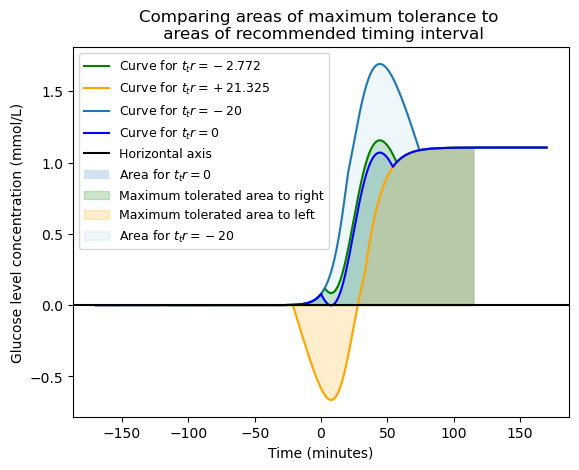

In [261]:
plt.plot(domain, combined_function_3, color="green")
plt.plot(domain, combined_function_4, color="orange")
plt.plot(domain, combined_function_5)
plt.plot(domain, combined_function, color="blue")
plt.axhline(color="black")
plt.fill_between(domain, combined_function, where = [(x > integral_start) and (x < integral_end) for x in domain], alpha=0.2)
plt.fill_between(domain, combined_function_3, where = [(x > integral_start) and (x < integral_end) for x in domain], color="green", alpha=0.2)
plt.fill_between(domain, combined_function_4, where = [(x > integral_start) and (x < integral_end) for x in domain], color="orange", alpha=0.2)
plt.fill_between(domain, combined_function_5, where = [(x > integral_start) and (x < integral_end) for x in domain], color="lightblue", alpha=0.2)
plt.legend(['Curve for $t_tr=-2.772$', 'Curve for $t_tr=+21.325$', 'Curve for $t_tr=-20$', 'Curve for $t_tr=0$', 'Horizontal axis', 'Area for $t_tr=0$', 'Maximum tolerated area to right', 'Maximum tolerated area to left', 'Area for $t_tr=-20$'], prop={"size":9})
plt.xlabel('Time (minutes)')
plt.ylabel('Glucose level concentration (mmol/L)')
plt.title('Comparing areas of maximum tolerance to \n areas of recommended timing interval')
plt.savefig(fname="Areas comparison maximum tolerance")